# **자연어 8일 - UnSupervised with NLP**
자연어 Token 데이터를 활용한 K-Means 의 구현

# **Search Engine Index 복습**
1. **DTM (Document Term Matrix) 모델 :** 전체 Token을 확인하여 검색 비용이 높다
1. **TDM (Term-Document Matrix) 모델 :** Token 별 **검색 Tree** 를 미리 재구성해 비용이 낮다

In [17]:
# 정규식에서 숫자는 : String Range 값을 특정 합니다
import os, re
fileFolder = "./News/" 
fileList   = [fileFolder + _  for _ in os.listdir(fileFolder) 
               if re.match("\d{10}.txt", _) ]

# 네이버 뉴스 수집자료를 collection 로 묶는다
collection = []
for _ in fileList:
    with open(_) as f:
        collection.append(f.read())

In [2]:
# DTM 모델링 (명사를 활용)
# DTM 자료형 : [Doc번호][Token][Freq]
from collections import defaultdict 
DTM = defaultdict(lambda:defaultdict(int))

from konlpy.tag import Mecab
for i, doc in enumerate(collection):
    for term in Mecab().nouns(doc):
        DTM[i][term] += 1

# Token 이 내용의 확인 : {doc1:{}}
print("Collection 문서 수:", len(DTM))
DTM[0]["교수"]  # DTM[문서 인덱스][검색 Token]

Collection 문서 수: 103


12

In [3]:
# TDM 모델링 (DTM 을 활용하여 색과 DB 생성)
# TDM 자료형 : [Token][Doc번호][빈도] => Token 의 문서색인 Tree
TDM = defaultdict(lambda:defaultdict(int))
for doc, termDict in DTM.items():
    for term, freq in termDict.items():
        TDM[term][doc] = freq

list(TDM.keys())[:12]

['오류', '우회', '함수', '추가', '교수', '점', '만점', '학생', '혁진', '코리아', '텍', '설문']

In [4]:
# Term Document -> Term Weight (TF-IDF) 값으로 변환
# TWM 자료형은 [Token][Doc번호][Tf-IDF]
TWM = defaultdict(lambda:defaultdict(float))
N   = len(collection)

from math import log2, sqrt
for t, docDict in TDM.items():
    for d, f in docDict.items():
        TF = f / max(DTM[d].values())
        IDF = log2(N / len(docDict))
        TWM[t][d] = TF * IDF

# **TWM 을 활용하여 문서를 K-means 로 분류하기**
## **1. Tf-IDF 빈도값 활용**
**data 자료 :** 저장하기 **[Doc번호][Token]**

In [5]:
# 데이터를 저장한 Base 자료 만들기
import numpy as np

V    = list(TWM.keys())
data = [list(np.zeros(len(V)))  for _ in range(len(DTM.keys()))]
print("Vocabulary : {}\nData shape : {} (문서, Token)".format(
    len(V), np.array(data).shape))

Vocabulary : 5431
Data shape : (103, 5431) (문서, Token)


In [6]:
# [Doc번호][Token][Tf-IDF]
for t, docDict in TWM.items():
    for d, w in docDict.items():
        #print(d,t,w)
        data[d][V.index(t)] = w

## **2 K-Means 함수들 가져오기**
1. Vector가 많아서 K-Means 는  **Cosine 유사도를** 사용하여 문서를 분류 합니다.

In [7]:
# 유클리드 거리측정 함수
from math import sqrt
def distance(x1, x2):
    _sum = .0
    for _x1, _x2 in zip(x1, x2):
        _sum += (_x1 - _x2)**2
    return sqrt(_sum)

# 원점에서 두 점 사이의 각도를 측정
def angle(x1, x2):
    innerProduct = .0  # 측정기준의 설정 (개별 K 노드를 기준)
    for _x1, _x2 in zip(x1, x2): 
        innerProduct += (_x1 * _x2)
    x1Length = distance(x1, [.0 for _ in range(len(x1))])
    x2Length = distance(x2, [.0 for _ in range(len(x2))])
    return innerProduct / (x1Length * x2Length)

# 유클리드 거리의 최소특정과 달리, 최댓값을 특정 합니다
def expectation(d, means):
    dist = [angle(d, centroid) for centroid in means]
    return dist.index(max(dist))

In [8]:
# 손실함수 J 
def _sse(Dk, centoid): 
    _sum = 0.0
    for d in Dk:
        _sum += angle(d, centroid)
    return _sum

In [9]:
# r_nk 는 {0,1} 의 값을 갖습니다.
# 위에서 생성한 r_nk 벡터에서 1의 값을 갖는 차원값을 추출 합니다
def maximization(Dk):
    C   = len(Dk)   # 개별 클러스터 분류된 갯수
    dim = len(Dk[0])
    
    # 클러스터 분류 데이터 갯수가 0인 경우
    if C == 0:
        return list(np.zeros(dim))

    # 유효한 분류내용이 있는경우 
    _sum = list(np.zeros(dim))
    for d in Dk:
        for i in range(dim):
            _sum[i] += d[i]            
    return [_/C   for _ in _sum]

## **3 K 를 2~10 개 늘리며 Simulation**
1. 위 불러온 함수를 사용하여 K 를 2~10 개 늘려가며 학습 합니다.
1. 반복하며 학습한 결과 내용을 Graph로 그려 최적의 K 를 찾습니다

In [10]:
%%time
# 함수들을 사용하여 임의의 K
from random import sample
sseList = []
for K in range(2,10):
    means = sample(data, K)

    for _ in range(10):
        r_nk = [ list(np.zeros(K))   for _ in range(N)]
        for i, d in enumerate(data):
            j = expectation(d, means)
            r_nk[i][j] = 1
            
        _sum, newMeans = 0.0, []
        for j, centroid in enumerate(means):
            Dk = [_   for i, _ in enumerate(data)
                      if  r_nk[i][j] == 1]
            newMeans.append(maximization(Dk))
            _sum += _sse(Dk, centroid)        
        means = newMeans
    sseList.append(_sum)    

CPU times: user 4min 44s, sys: 216 ms, total: 4min 44s
Wall time: 4min 45s


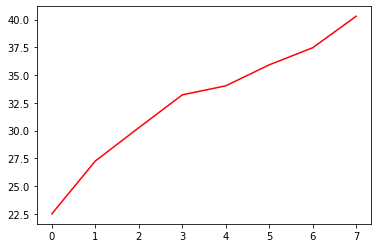

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(range(len(sseList)), sseList, "r-")
plt.show()

## **4 K = 5 일때 데이터 만들기**
1. 가장 나쁜 형태는 **sseList() 결과가 선형으로 보이는 것** 입니다.
1. 이번에는 그나마 기울기가 완만해지는 K=4 점을 두드러진 값으로 보고 모델을 만듭니다

In [12]:
%%time
K = 4
sseList = []

from random import sample
means   = sample(data, K)

for _ in range(10):
    r_nk = [ list(np.zeros(K))   for _ in range(N)]
    for i, d in enumerate(data):
        j = expectation(d, means)
        r_nk[i][j] = 1

    _sum = 0.0
    newMeans = []
    for j, centroid in enumerate(means):
        Dk = [_   for i, _ in enumerate(data)
                  if  r_nk[i][j] == 1]
        newMeans.append(maximization(Dk))
        _sum += _sse(Dk, centroid)        
    means = newMeans
    sseList.append(_sum)

for i in range(K):
    print(i+1, "번째 클러스터")
    print([j for j, _ in enumerate(r_nk) if _[i] == 1])

1 번째 클러스터
[5, 8, 17, 25, 26, 35, 37, 49, 51, 52, 53, 55, 56, 57, 70, 75, 91, 96]
2 번째 클러스터
[0, 19, 24, 30, 38, 59, 65, 76, 80, 84, 92, 97, 101]
3 번째 클러스터
[4, 12, 13, 14, 31, 33, 39, 40, 41, 42, 44, 45, 48, 58, 69, 71, 79, 86, 87, 93, 99, 100]
4 번째 클러스터
[1, 2, 3, 6, 7, 9, 10, 11, 15, 16, 18, 20, 21, 22, 23, 27, 28, 29, 32, 34, 36, 43, 46, 47, 50, 54, 60, 61, 62, 63, 64, 66, 67, 68, 72, 73, 74, 77, 78, 81, 82, 83, 85, 88, 89, 90, 94, 95, 98, 102]
CPU times: user 27.9 s, sys: 16 ms, total: 27.9 s
Wall time: 27.9 s


## **5 Word Cloud (Visualization)**
1. **대표적 토픽의 빈도가** 두드러 지며 잘 묶일 때 효과적인 분류로 판단이 가능
1. 판단은 **Huristic 한 방식으로 사람이 결과를 해석하며** 분류의 특징을 찾습니다
1. **군집으로 단어들이 모인** 경우에는 **WordCloud** 를 활용하는게 유용하다
1. 폰트파일의 설정이 필요합니다 **$ fc-list | grep D2** 를  입력합니다

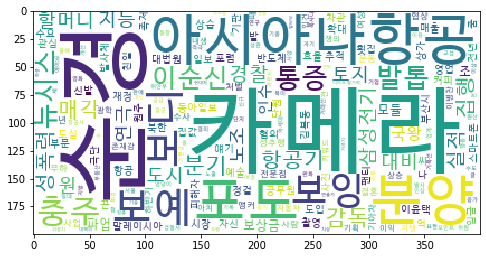

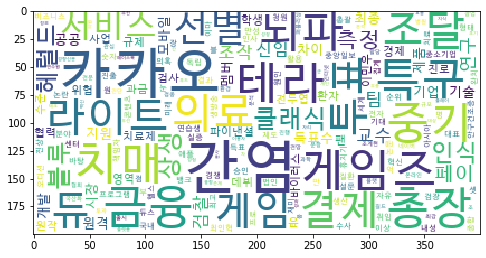

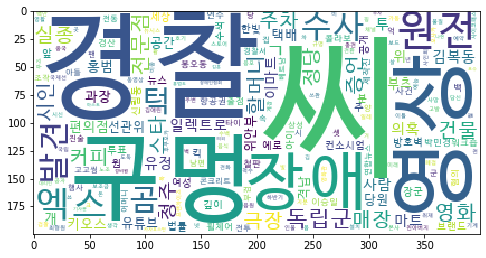

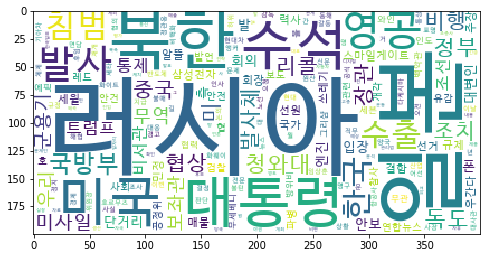

In [16]:
from wordcloud import WordCloud

font = "/home/markbaum/.local/share/fonts/D2Coding.ttf"
wc   = WordCloud(font_path=font, # max_words=10,
                 background_color="white")

for k in range(K):
    plt.figure(figsize=(8,6))
    tags = {t:w for w, t in zip(means[k], V)}
    wc.generate_from_frequencies(tags)
    plt.imshow(wc.to_array())
    plt.show()